In [ ]:
!nvidia-smi

Mon Mar 29 12:10:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers==3

     |████████████████████████████████| 757kB 19.2MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
     |████████████████████████████████| 1.2MB 57.5MB/s 
     |████████████████████████████████| 3.0MB 48.9MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 3.0.0



In [ ]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data /content/drive/MyDrive/TFG/Datasets_procesados 2
path = "drive/MyDrive/TFG_1/Datasets_procesados/train/amazonEN_train.csv"
df = pd.read_csv(path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.head(1000)
df.head()

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0094023,product_en_0192188,reviewer_en_0358484,2,The color was a little bit different but it fi...,Good for the price,en,apparel,Good for the price The color was a little bit ...,Good for the price The color was a little bit ...,The color was a little bit different but it fi...,0
1,en_0105984,product_en_0891028,reviewer_en_0321717,3,Kinda stings in the eye when infected. I have ...,"Worth a try, be patient with results!",en,beauty,"Worth a try, be patient with results! Kinda st...","Worth a try, be patient with results! Kinda st...",Kinda stings in the eye when infected. I have ...,3
2,en_0921862,product_en_0823908,reviewer_en_0105317,2,The case does not work very well in the positi...,Viewing position not useful due to poor design,en,pc,Viewing position not useful due to poor design...,Viewing position not useful due to poor design...,The case does not work very well in the positi...,22
3,en_0265074,product_en_0263022,reviewer_en_0618064,1,Disappointed with this purchase! After 1yr I s...,Not happy,en,apparel,Not happy Disappointed with this purchase! Aft...,Not happy Disappointed with this purchase! Aft...,Disappointed with this purchase! After 1yr I s...,0
4,en_0012395,product_en_0806668,reviewer_en_0951950,3,more green then the first picture,Four Stars,en,toy,Four Stars more green then the first picture,Four Stars more green then the first picture toy,more green then the first picture toy,27


In [ ]:
path_val = "drive/MyDrive/TFG_1/Datasets_procesados/valid/amazonEN_valid.csv"
df_val = pd.read_csv(path_val)
path_test = "drive/MyDrive/TFG_1/Datasets_procesados/test/amazonEN_test.csv"
df_test = pd.read_csv(path_test)

## Data Preprocessing


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length


In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt', # Return PyTorch tensors
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.float)
    }

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review_body.to_numpy(),
    targets=df.star_rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) 
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# MSE APPROACH 

class SentimentPrediction(nn.Module):

  def __init__(self):
    super(SentimentPrediction, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 1)  # en vez de numero de clases solo 1 para hacer regresion
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # tensor 2D, nºejemplos * 768 embeddings del token [CLS] representativo de la secuencia 

    output = self.drop(pooled_output) # capa dropout 
    return self.out(output) # capa lineal 



This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(5) 
#model = model.to(device)

In [ ]:
model = SentimentPrediction()
model = model.to(device)

In [ ]:
print(model
  )

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length 
print(targets.shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
print(targets)

tensor([2., 3., 2., 1., 3., 1., 3., 2., 0., 2., 4., 2., 4., 3., 4., 4.],
       device='cuda:0')


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
out1 = model(input_ids, attention_mask)
out1.shape

torch.Size([16, 1])

In [ ]:
out1

tensor([[ 0.7667],
        [ 0.2750],
        [ 0.1844],
        [ 0.8314],
        [ 0.7194],
        [ 0.0975],
        [ 0.4258],
        [ 0.0469],
        [ 0.3678],
        [-0.0397],
        [ 0.3514],
        [ 0.7588],
        [ 0.6216],
        [ 0.1911],
        [ 0.5707],
        [ 0.2779]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
out2 =F.sigmoid(model(input_ids, attention_mask))
out2.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([16, 1])

In [ ]:
out2

tensor([[0.6108],
        [0.6984],
        [0.6362],
        [0.6668],
        [0.5454],
        [0.5552],
        [0.6818],
        [0.6838],
        [0.6283],
        [0.5447],
        [0.6248],
        [0.4799],
        [0.7026],
        [0.6928],
        [0.4921],
        [0.6842]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
for i in out2:
 pred = i * targets

In [ ]:
pred

tensor([1.3685, 2.0527, 1.3685, 0.6842, 2.0527, 0.6842, 2.0527, 1.3685, 0.0000,
        1.3685, 2.7370, 1.3685, 2.7370, 2.0527, 2.7370, 2.7370],
       device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
targets

tensor([2., 3., 2., 1., 3., 1., 3., 2., 0., 2., 4., 2., 4., 3., 4., 4.],
       device='cuda:0')

In [ ]:
for i in out2:
  if i > 0.5:
    pred = targets
  else: 
    pred = targets-1


In [ ]:
pred

tensor([2., 3., 2., 1., 3., 1., 3., 2., 0., 2., 4., 2., 4., 3., 4., 4.],
       device='cuda:0')

### Training

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=3e-7, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)
#loss_fn = nn.L1Loss().to(device) ## MAE

### Continue training

In [ ]:
from sklearn.metrics import mean_squared_error

## train de regresion 

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  sum_loss = 0.0
  total = 0

  for d in data_loader: 
    input_ids = d["input_ids"].to(device)         
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = F.sigmoid(outputs) * targets # probabilidad de que sea la target correcta (normalizada) multiplicada por la correcta nos da el valor float que predice el modelo
  
    
    loss = loss_fn(preds, targets.float()) # MSE sobre las predicciones y las labels

    #correct_predictions += torch.sum(preds == targets) 
    sum_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #para evitar exploding gradient
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return  np.sqrt(loss.cpu().detach().numpy()), np.mean(sum_loss)

In [ ]:
## validation de regresion

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  sum_loss = 0.0
  total = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device) 

      outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    
      preds = F.sigmoid(outputs) * targets # probabilidad de que sea la target correcta (normalizada) multiplicada por la correcta nos da el valor float que predice el modelo
    
      loss = loss_fn(preds, targets.float()) # MSE sobre las predicciones y las labels 
      
      sum_loss += loss.item()
      #correct_predictions += torch.sum(preds == targets)
      

  return np.sqrt(loss.cpu().detach().numpy()), np.mean(sum_loss)



In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df)
  )

  print(f'Train loss {train_loss} MSE: {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} MSE: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Train loss 31.706742525100708 MSE: 0.5613340735435486


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val   loss 68.3647146821022 MSE: 0.6362912058830261

Epoch 2/3
----------
Train loss 31.581893652677536 MSE: 0.7118759155273438
Val   loss 68.3647146821022 MSE: 0.6362912058830261

Epoch 3/3
----------
Train loss 32.44408053159714 MSE: 0.5588966012001038
Val   loss 68.3647146821022 MSE: 0.6362912058830261

CPU times: user 1min 24s, sys: 1min 11s, total: 2min 35s
Wall time: 2min 37s


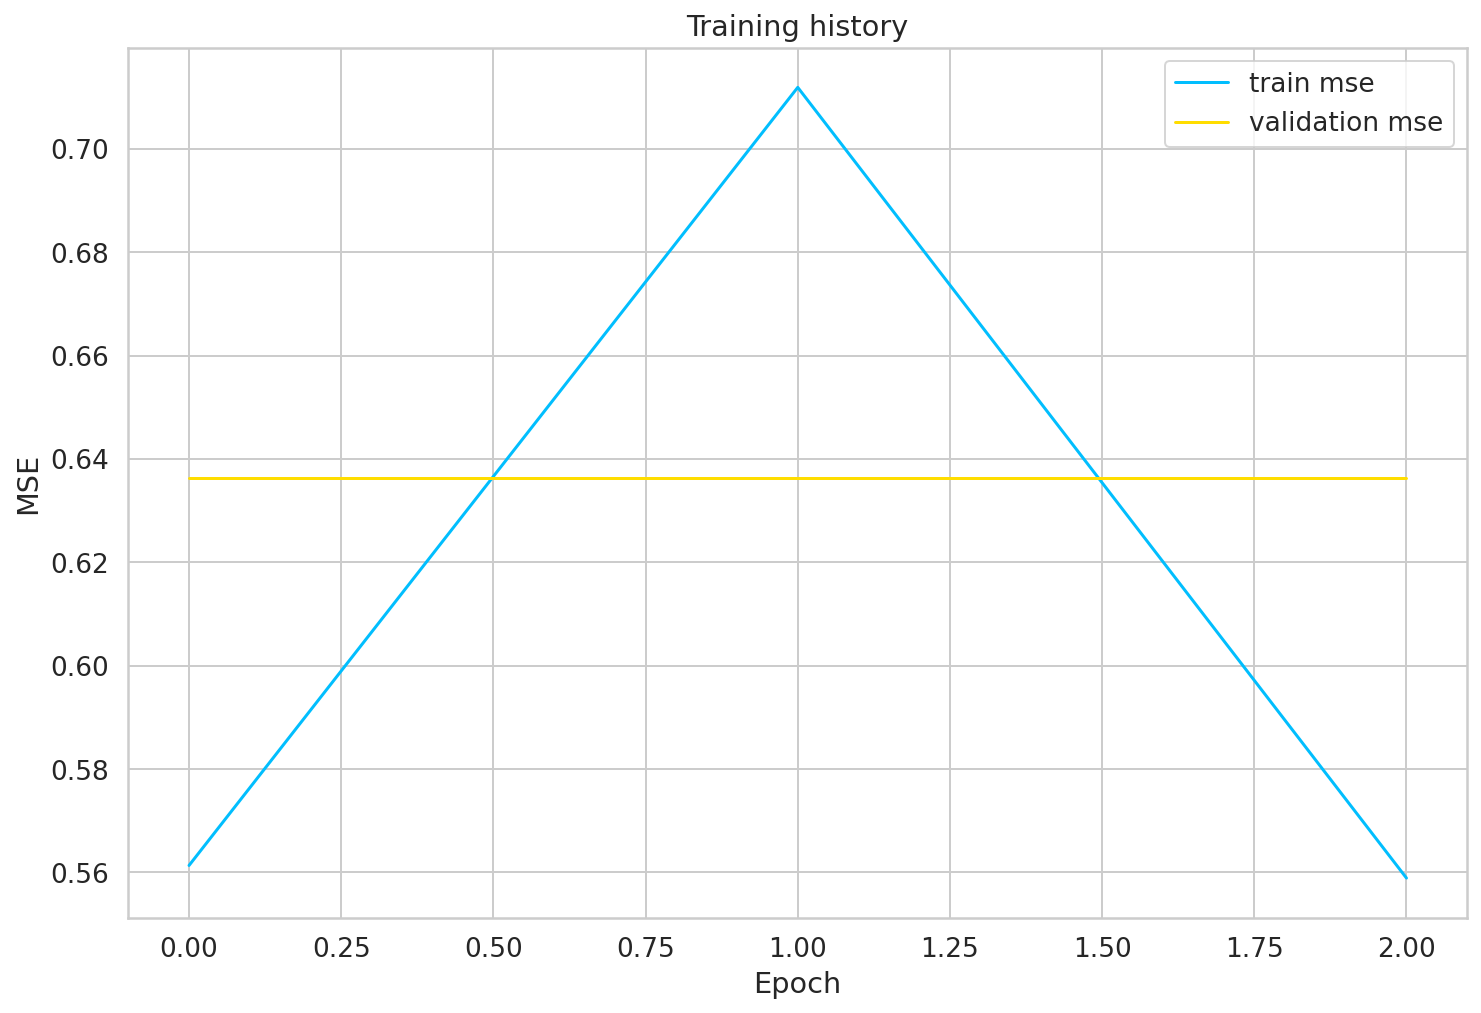

In [ ]:
plt.plot(history['train_acc'], label='train mse')
plt.plot(history['val_acc'], label='validation mse')

plt.title('Training history')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()


## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
MSE_test, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

MSE_test.item()

5.485389703227539e-13

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  reg = LinearRegression()

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = F.relu(model(
        input_ids=input_ids,
        attention_mask=attention_mask
      ))
     # _, preds = torch.max(outputs, dim=1)
      regression = reg.fit(outputs.cpu().detach().numpy(),targets.cpu())
      reg_preds = regression.predict(outputs.cpu().detach().numpy())
      reg_preds = torch.from_numpy(reg_preds)

      #review_text.extend(texts)
      predictions.extend(reg_preds)
      #prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  #prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

ValueError: ignored

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.37      0.87      0.52       480
           2       1.00      0.00      0.00       530
           3       0.10      0.14      0.11       501
           4       0.00      0.00      0.00       479
           5       0.15      0.19      0.17       510

    accuracy                           0.23      2500
   macro avg       0.32      0.24      0.16      2500
weighted avg       0.33      0.23      0.16      2500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


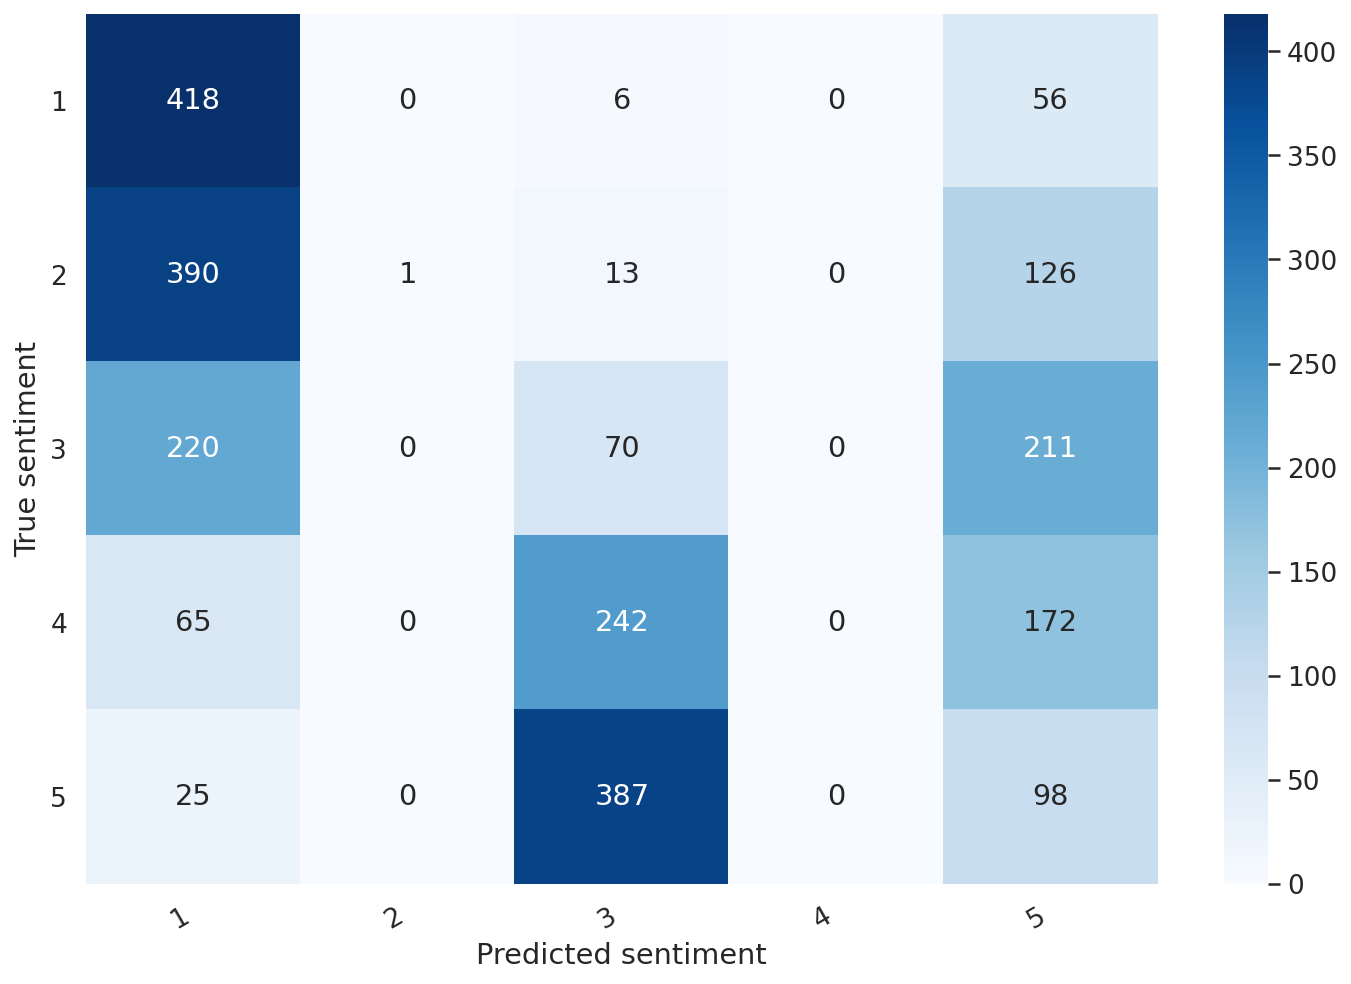

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['1','2','3','4','5'], columns=['1','2','3','4','5'])
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

Now we can look at the confidence of each sentiment of our model:

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "NOT what I expected, this is pure trash!!! "

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)


output = model(input_ids, attention_mask)
#_, prediction = torch.max(output, dim=1)
reg = LinearRegression()
regression = reg.fit(output.cpu().detach().numpy(),target.cpu())
reg_preds = reg.predict(output.cpu().detach().numpy())
reg_preds = torch.from_numpy(reg_preds)

print(f'Review text: {review_text}')
print(f'Sentiment  : {reg_preds}')

NotFittedError: ignored

## Regresión pruebas

In [ ]:
from sklearn.linear_model import LinearRegression
loss_fn = nn.L1Loss().to(device) ## MAE

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
target = data['targets'].to(device)

output = model(input_ids,attention_mask)

In [ ]:
output.shape  ## 768 " features" = embeddings de la salida de Bert 

torch.Size([8, 768])

In [ ]:
target.shape 

torch.Size([8])

In [ ]:
reg = LinearRegression().fit(output.cpu().detach().numpy(),target.cpu().detach().numpy())   # hacemos linear regresion con las features y la target

In [ ]:
pred = reg.predict(output.cpu().detach().numpy())      ## predecimos el rating con los datos que ya ha visto al hacer fit (train)
pred

array([2.       , 3.       , 2.0000002, 1.0000002, 3.       , 1.       ,
       2.9999993, 2.0000005], dtype=float32)

In [ ]:
print(pred.dtype)
print(target.dtype)

float32
float32


In [ ]:
#target = target.cpu().detach().numpy()
loss_fn(pred,target)        ## calculamos loss entre prediccion y target 

TypeError: ignored

In [ ]:
## del dataset de validation creamos los outputs de Bert  = 'features' 
data_val = next(iter(val_data_loader))
data_val.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids_val = data_val['input_ids'].to(device)
attention_mask_val= data_val['attention_mask'].to(device)
targets_valid = data_val['targets'].to(device)

In [ ]:
output_val = model(input_ids_val,attention_mask_val)  ## features 
output_val.shape

torch.Size([8, 768])

In [ ]:
pred_valid = reg.predict(output_val.cpu().detach().numpy())  ## predecimos sobre el output del bloque valid que no ha visto en el fit
pred_valid

array([2.3461123, 2.1015475, 2.0584323, 2.0419493, 2.1033006, 2.1911607,
       2.1752102, 2.1674774], dtype=float32)

In [ ]:
print(pred_valid)
print(targets_valid)

[2.3461123 2.1015475 2.0584323 2.0419493 2.1033006 2.1911607 2.1752102
 2.1674774]
tensor([0., 2., 2., 1., 2., 0., 1., 4.], device='cuda:0')


In [ ]:
loss_fn(pred_valid,targets_valid)

TypeError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader: 
    input_ids = d["input_ids"].to(device)         
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)  ## target asociada a la probabilidad
    loss = loss_fn(outputs, targets)   ## loss sobre la predicción y la salida

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #para evitar exploding gradient
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return mean_squared_error(targets.cpu().detach().numpy(), preds.cpu().detach().numpy()), np.mean(losses)

In [ ]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
out